In [1]:
# Imports and settings

import os
import pandas as pd
from PIL import Image
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from concurrent.futures import ThreadPoolExecutor

In [2]:
# Load metadata CSV

df = pd.read_csv("balanced_metadata.csv")

# Filter for images that contain an animal
df = df[df["has_animal"] == 1].reset_index(drop=True)

image_path_prefix = "Orinoquia_Carma_Traps/orinoquia_camera_traps_images/public/"

df = df.iloc[:, 1:]

print(f"Dataframe length: {len(df)}")

cat2idx = {cat: i for i, cat in enumerate(sorted(df["category_id"].unique()))}
idx2cat = {v: k for k, v in cat2idx.items()}

df["cat_idx"] = df["category_id"].map(cat2idx)   # new integer column
NUM_CLASSES   = len(cat2idx)

print(f"number of classes {NUM_CLASSES}")

df.head()

Dataframe length: 19794
number of classes 50


,id,datetime,file_name,seq_id,frame_num,seq_num_frames,location,category_id,has_animal,species,cat_idx
0,N25_102EK113_04280033.JPG,2020-04-28 02:18:59+00:00,N25/102EK113/04280033.JPG,398e7044-7160-11ec-820f-5cf3706028c2,5,12,N25,3,1,collared_peccary,2
1,N27_102EK113_06210753.JPG,2020-06-21 15:23:08+00:00,N27/102EK113/06210753.JPG,396b00d8-7160-11ec-b898-5cf3706028c2,2,3,N27,2,1,black_agouti,1
2,M01_100EK113_02180585.JPG,2020-02-18 18:12:48+00:00,M01/100EK113/02180585.JPG,39731938-7160-11ec-a7c8-5cf3706028c2,8,30,M01,2,1,black_agouti,1
3,N09_100EK113_01120102.JPG,2020-01-12 12:39:51+00:00,N09/100EK113/01120102.JPG,39b31844-7160-11ec-be06-5cf3706028c2,2,6,N09,1,1,human,0
4,M04_100EK113_01220825.JPG,2020-01-22 21:43:45+00:00,M04/100EK113/01220825.JPG,39a50b1b-7160-11ec-9853-5cf3706028c2,5,6,M04,3,1,collared_peccary,2


In [3]:
# # load image tensor as (N, C, H, W)
# # N: image count = len(df) = 19,794
# # C: channels = 3
# # H: height = 224
# # W: width = 224

# TARGET_SIZE = (224, 224)  # For ResNet18
# def load_image_for_resnet(full_path):
#     with Image.open(full_path) as im:
#         im = im.convert("RGB").resize(TARGET_SIZE)
#         arr = np.asarray(im, dtype=np.uint8)

#         # Convert (H, W, C) to (C, H, W)
#         return np.transpose(arr, (2, 0, 1))

# paths = (os.path.join(image_path_prefix, p) for p in df["file_name"])

# with ThreadPoolExecutor(max_workers=os.cpu_count()) as exe:
#     X = np.asarray(list(exe.map(load_image_for_resnet, paths)))

# print("Image tensor shape:", X.shape)  # Should be (N, 3, 224, 224)

# np.save("artifact/orinoquia_resnet18_imageset.npy", X)

In [4]:
# if artifact is saved
X = np.load("artifact/orinoquia_resnet18_imageset.npy")

In [5]:
display(X)

array([[[[ 20,  20,  20, ...,  19,  19,  18],
         [ 20,  20,  20, ...,  18,  19,  19],
         [ 20,  20,  20, ...,  20,  19,  20],
         ...,
         [184, 211, 215, ..., 255, 255, 255],
         [184, 211, 215, ..., 255, 255, 255],
         [180, 209, 215, ..., 235, 234, 233]],

        [[ 20,  20,  20, ...,  19,  19,  18],
         [ 20,  20,  20, ...,  18,  19,  19],
         [ 20,  20,  20, ...,  20,  19,  20],
         ...,
         [106,  98,  92, ..., 251, 251, 251],
         [106,  98,  93, ..., 253, 253, 253],
         [101,  97,  93, ..., 231, 230, 230]],

        [[ 20,  20,  20, ...,  19,  19,  18],
         [ 20,  20,  20, ...,  18,  19,  19],
         [ 20,  20,  20, ...,  20,  19,  20],
         ...,
         [ 76,  54,  43, ..., 255, 255, 255],
         [ 77,  54,  43, ..., 255, 255, 255],
         [ 71,  53,  43, ..., 235, 234, 234]]],


       [[[ 48,  87, 126, ..., 104, 148,  76],
         [ 39,  77, 104, ...,  99,  64,  40],
         [ 49,  70,  91, ..., 

In [6]:
from typing import Tuple

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from torchvision import transforms as T

# helpers

# always-present tail of the transform pipeline
base_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],  # ResNet-18 values
                std=[0.229, 0.224, 0.225]),
])

def merge_transforms(augment: T.Compose | None = None) -> T.Compose:
    """
    Return a Compose that is `augment` followed by the common base_transform.
    If `augment` is None, you just get the base_transform.
    """
    if augment is None:
        return base_transform
    return T.Compose(augment.transforms + base_transform.transforms)


# dataset
class CameraTrapDataset(Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        images: np.ndarray,           # shape (N, 3, 224, 224)
        index: pd.Index,
        transform: T.Compose | None = None,
    ):
        self.df = df
        self.images = images
        self.index = index
        self.transform = merge_transforms(transform) if transform is not None else base_transform

    def __len__(self) -> int:
        return len(self.index)

    def __getitem__(self, idx: int):
        row_idx = self.index[idx]
        row = self.df.iloc[row_idx]

        img = self.images[row_idx] # ndarray (3, 224, 224)
        img = T.ToPILImage()(img.transpose((1, 2, 0)))
        img = self.transform(img) # tensor (3, 224, 224)

        label = torch.tensor(row["cat_idx"], dtype=torch.long) # ()

        return img, label

def make_train_val_index(
    df: pd.DataFrame, train_ratio: float = 0.9
) -> Tuple[pd.Index, pd.Index]:
    shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)
    split = int(train_ratio * len(shuffled))
    return shuffled.index[:split], shuffled.index[split:]

train_idx, val_idx = make_train_val_index(df)

train_ds = CameraTrapDataset(df, X, train_idx, transform=T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
]))

val_ds = CameraTrapDataset(df, X, val_idx, transform=None)

print(f"Training size: {len(train_ds)}")
print(f"Validation size: {len(val_ds)}")

Training size: 17814
Validation size: 1980


In [7]:
from time import time

t0 = time()
img, label = train_ds[0]
print("Single image load time:", time() - t0)

Single image load time: 0.003998994827270508


In [8]:
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=0)

imgs, labels = next(iter(train_dl))

# imgs (BATCH_SIZE, 3, 224, 224)
# labels (BATCH_SIZE)
# 0 = no animal, 1 = animal
print(imgs.shape, labels.shape, labels.unique())

torch.Size([32, 3, 224, 224]) torch.Size([32]) tensor([ 1,  2,  3,  4,  5,  7,  9, 10, 14, 15, 20, 23, 34])


In [9]:
from torchvision import models
from tqdm import tqdm

from torch.optim.lr_scheduler import MultiStepLR
import torch.nn as nn

class MLPClassificationHead(nn.Module):
    def __init__(self, in_features, num_classes):
        super().__init__()
        self.head = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.head(x)

LR = 1e-4

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using Device {DEVICE}")

resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# no finetune
for name, p in resnet.named_parameters():
    p.requires_grad = False

in_features = resnet.fc.in_features
resnet.fc = MLPClassificationHead(in_features, NUM_CLASSES)
resnet = resnet.to(DEVICE)

optimizer = optim.Adam(resnet.fc.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

scheduler = MultiStepLR(optimizer, milestones=[5], gamma=0.3)

@torch.no_grad()
def run_eval_epoch(model, dataloader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    for imgs, labels in tqdm(dataloader, desc="Val  ", leave=False):
        imgs   = imgs.to(DEVICE)
        labels = labels.to(DEVICE)

        logits = model(imgs)
        loss   = criterion(logits, labels)

        running_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(dim=1) # (B,)
        correct += (preds == labels).sum().item()
        total   += imgs.size(0)

    return running_loss / total, correct / total

Using Device cuda


[01/10] lr 0.000100 | train loss 2.5796  acc 0.290 | val loss 2.3826  acc 0.309


[02/10] lr 0.000100 | train loss 2.3403  acc 0.332 | val loss 2.2712  acc 0.337


[03/10] lr 0.000100 | train loss 2.2784  acc 0.349 | val loss 2.2231  acc 0.354


[04/10] lr 0.000100 | train loss 2.2168  acc 0.367 | val loss 2.1880  acc 0.361


[05/10] lr 0.000030 | train loss 2.1894  acc 0.371 | val loss 2.1574  acc 0.371


[06/10] lr 0.000030 | train loss 2.1444  acc 0.385 | val loss 2.1397  acc 0.376


[07/10] lr 0.000030 | train loss 2.1381  acc 0.387 | val loss 2.1303  acc 0.378


[08/10] lr 0.000030 | train loss 2.1108  acc 0.394 | val loss 2.1319  acc 0.373


[09/10] lr 0.000030 | train loss 2.1178  acc 0.389 | val loss 2.1197  acc 0.386


[10/10] lr 0.000030 | train loss 2.1154  acc 0.395 | val loss 2.1192  acc 0.384


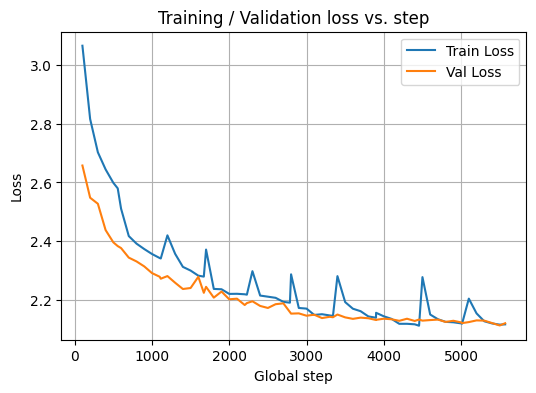

In [10]:
EVAL_EVERY = 100          # batches
NUM_EPOCHS = 10

history = {
    "step":        [],
    "epoch":       [],
    "train_loss":  [],
    "val_loss":    [],
    "train_acc":   [],
    "val_acc":     [],
}

global_step = 0
for epoch in range(1, NUM_EPOCHS + 1):
    resnet.train()
    running_loss, correct, seen = 0.0, 0, 0

    pbar = tqdm(train_dl, desc=f"Epoch {epoch}", leave=False)
    for imgs, labels in pbar:
        global_step += 1

        imgs   = imgs.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        logits = resnet(imgs) # (B, NUM_CLASSES)
        loss   = criterion(logits, labels) # labels: (B,)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(dim=1) # (B,)
        correct += (preds == labels).sum().item()
        seen    += imgs.size(0)

        if global_step % EVAL_EVERY == 0:
            train_loss = running_loss / seen
            train_acc  = correct / seen

            val_loss, val_acc = run_eval_epoch(
                model=resnet,
                dataloader=val_dl,
                criterion=criterion,
            )

            history["step"].append(global_step)
            history["epoch"].append((epoch - 1) + seen / len(train_dl.dataset))
            history["train_loss"].append(train_loss)
            history["val_loss"].append(val_loss)
            history["train_acc"].append(train_acc)
            history["val_acc"].append(val_acc)

            pbar.set_postfix({
                "tr_loss": f"{train_loss:.3f}",
                "val_loss": f"{val_loss:.3f}",
                "val_acc": f"{val_acc:.3f}",
            })

    scheduler.step()

    val_loss, val_acc = run_eval_epoch(
        model=resnet,
        dataloader=val_dl,
        criterion=criterion,
    )
    train_loss = running_loss / seen
    train_acc  = correct / seen

    history["step"].append(global_step)
    history["epoch"].append(epoch)
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(f"[{epoch:02}/{NUM_EPOCHS}] "
          f"lr {scheduler.get_last_lr()[0]:.6f} | "
          f"train loss {train_loss:.4f}  acc {train_acc:.3f} | "
          f"val loss {val_loss:.4f}  acc {val_acc:.3f}")

df_history = pd.DataFrame(history)

plt.figure(figsize=(6,4))
plt.plot(df_history["step"], df_history["train_loss"], label="Train Loss")
plt.plot(df_history["step"], df_history["val_loss"],   label="Val Loss")
plt.xlabel("Global step")
plt.ylabel("Loss")
plt.title("Training / Validation loss vs. step")
plt.legend(); plt.grid(True); plt.show()

In [11]:

# cat idx -> species

import numpy as np, pandas as pd, torch, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# cat_id ➜ species   (1-to-1 in your CSV)
catid2species = dict(df[["category_id", "species"]].drop_duplicates().values)

# idx (0..49) ➜ species
idx2species = {i: catid2species[cat_id] for i, cat_id in idx2cat.items()}


In [12]:


# Collect predictions on the validation set

all_preds, all_labels = [], []

resnet.eval()
with torch.no_grad():
    for imgs, labels in val_dl:
        imgs   = imgs.to(DEVICE)
        logits = resnet(imgs)
        preds  = logits.argmax(1).cpu().numpy()  # (B,)
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

all_preds  = np.asarray(all_preds)
all_labels = np.asarray(all_labels)


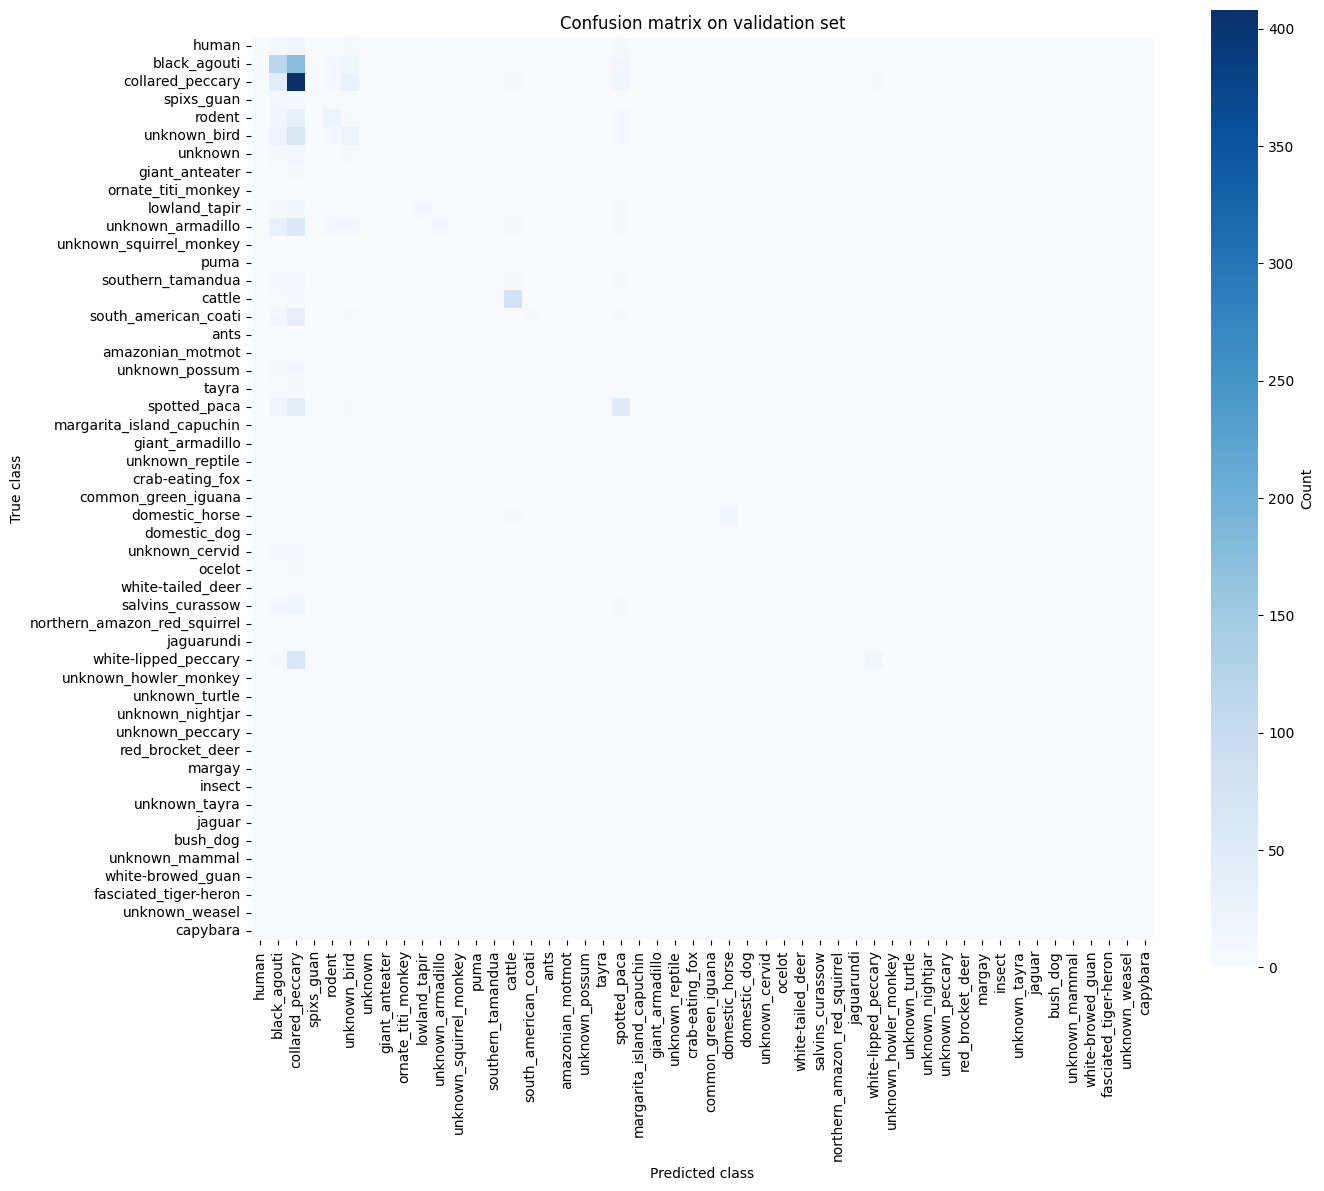

In [13]:

# Confusion matrix (50 × 50)
cm = confusion_matrix(all_labels, all_preds, labels=np.arange(NUM_CLASSES))

fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(
    cm,
    ax=ax,
    cmap="Blues",
    square=True,
    cbar_kws={"label": "Count"},
    xticklabels=[idx2species[i] for i in range(NUM_CLASSES)],
    yticklabels=[idx2species[i] for i in range(NUM_CLASSES)],
)
ax.set_xlabel("Predicted class")
ax.set_ylabel("True class")
ax.set_title("Confusion matrix on validation set")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [14]:

# Per-species TP / FP / FN / TN, plus rates
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum()       - (TP + FP + FN)

metrics = pd.DataFrame({
    "species"   : [idx2species[i] for i in range(NUM_CLASSES)],
    "TP"        : TP,
    "FP"        : FP,          # Type I error
    "FN"        : FN,          # Type II error
    "TN"        : TN,
})

# add rates
metrics["TP_rate"] = metrics["TP"] / (metrics["TP"] + metrics["FN"]).replace(0, np.nan)
metrics["FP_rate"] = metrics["FP"] / (metrics["FP"] + metrics["TN"]).replace(0, np.nan)
metrics["FN_rate"] = 1 - metrics["TP_rate"]

# top-5 species by each category
def top(df, col, k=5, asc=False):
    return df.sort_values(col, ascending=asc).head(k)[["species", col]]

print("\n▶ Top-5 by true positives")
display(top(metrics, "TP", 5, asc=False))

print("\n▶ Top-5 by false positives (Type I)")
display(top(metrics, "FP", 5, asc=False))

print("\n▶ Top-5 by false negatives (Type II)")
display(top(metrics, "FN", 5, asc=False))

print("\n▶ Top-5 by highest TP rate (recall)")
display(top(metrics, "TP_rate", 5, asc=False))

print("\n▶ Top-5 by highest FP rate (false alarm)")
display(top(metrics, "FP_rate", 5, asc=False))



▶ Top-5 by true positives


,species,TP
2,collared_peccary,408
1,black_agouti,115
14,cattle,77
20,spotted_paca,50
4,rodent,25



▶ Top-5 by false positives (Type I)


,species,FP
2,collared_peccary,605
1,black_agouti,243
5,unknown_bird,109
20,spotted_paca,94
4,rodent,60



▶ Top-5 by false negatives (Type II)


,species,FN
1,black_agouti,226
2,collared_peccary,119
10,unknown_armadillo,116
5,unknown_bird,108
34,white-lipped_peccary,82



▶ Top-5 by highest TP rate (recall)


,species,TP_rate
14,cattle,0.819149
2,collared_peccary,0.774194
26,domestic_horse,0.708333
20,spotted_paca,0.390625
1,black_agouti,0.337243



▶ Top-5 by highest FP rate (false alarm)


,species,FP_rate
2,collared_peccary,0.416380
1,black_agouti,0.148261
5,unknown_bird,0.059015
20,spotted_paca,0.050756
4,rodent,0.031797


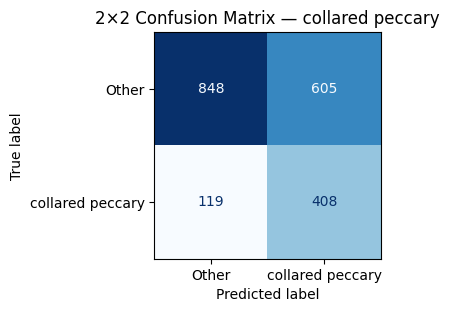

collared_peccary — TP: 408, FP: 605, FN: 119, TN: 848 | Precision: 0.403  Recall: 0.774


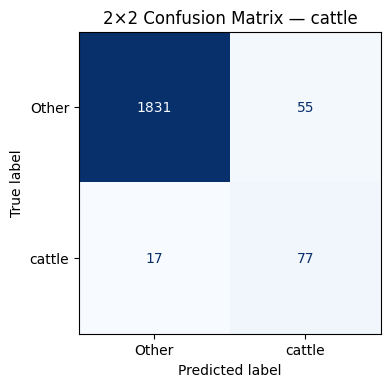

cattle — TP: 77, FP: 55, FN: 17, TN: 1831 | Precision: 0.583  Recall: 0.819


In [15]:

# 2×2 confusion matrix for a particular species

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_binary_cm(species_name: str):
    """
    Plot a 2×2 confusion matrix for `species_name` on the validation set.
    """
    # ---------------- lookup index ----------------
    try:
        idx_target = next(i for i, sp in idx2species.items() if sp == species_name)
    except StopIteration:
        raise ValueError(f"Species '{species_name}' not found. Check spelling?")
    
    # ---------------- build binary labels ----------------
    y_true_bin = (all_labels == idx_target).astype(int)  # 1 = this species
    y_pred_bin = (all_preds  == idx_target).astype(int)
    
    cm2 = confusion_matrix(y_true_bin, y_pred_bin, labels=[0, 1])
    tn, fp, fn, tp = cm2.ravel()
    
    # ---------------- plot ----------------
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm2,
        display_labels=["Other", species_name.replace("_", " ")]
    )
    fig, ax = plt.subplots(figsize=(4, 4))
    disp.plot(ax=ax, cmap="Blues", values_format="d", colorbar=False)
    ax.set_title(f"2×2 Confusion Matrix — {species_name.replace('_', ' ')}")
    plt.tight_layout()
    plt.show()
    
    # ---------------- quick printout ----------------
    print(
        f"{species_name} — TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn} | "
        f"Precision: {tp/(tp+fp):.3f}  Recall: {tp/(tp+fn):.3f}"
        if (tp+fp)*(tp+fn) else ""
    )

plot_binary_cm("collared_peccary")
plot_binary_cm("cattle")